# Brain Tumor Detection- Keras/Pytorch 🧠🧠
* https://www.kaggle.com/code/fahadmehfoooz/brain-tumor-detection-keras-pytorch
---

### data
* 
* 

## 1. Importing Modules

In [4]:
import os, glob, pathlib # 파일 위치 찾기, 입출력 등
# from tqdm import tqdm # 진행 상황 표시 모듈 -> 반복문에서 현재 상태를 시각화, 진행률과 소요 시간 등 표시
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
# %matplotlib inline

In [5]:
import cv2
from skimage.io import imread
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [6]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
from torch.autograd import Variable

import torchvision
from torchvision.transforms import transforms

In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D
from tensorflow.keras.optimizers import Adam
from kerastuner import RandomSearch

## 2. Data

### 1) Loading

In [8]:
# kaggle api
# !kaggle datasets download sartajbhuvaji/brain-tumor-classification-mri

In [9]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("sartajbhuvaji/brain-tumor-classification-mri")

# print("Path to dataset files:", path)

In [10]:
TRAIN_PATH = '../data/brain-tumor-classification-mri/Training'
TEST_PATH = '../data/brain-tumor-classification-mri/Testing'

In [11]:
img_size = 300

In [12]:
# train dataset
train_img = []
train_label = []

tqdm_label = tqdm(os.listdir(TRAIN_PATH))
for label in tqdm_label:
    tqdm_image = tqdm(os.listdir(TRAIN_PATH+'/'+label))
    for image in tqdm_image:
        img = cv2.imread(TRAIN_PATH+'/'+label+'/'+image) # 이미지 파일 읽기 (ndarray)
        # print(type(img))
        img_resized = cv2.resize(img, (img_size, img_size)) # 이미지 크기 변경 (ndarray)
        # print(type(img_resized))
        train_img.append(img_resized)
        train_label.append(label)
    tqdm_image.close()
tqdm_label.close()

train_img = np.array(train_img) # 데이터 타입 변경 (list -> ndarray)

print('Shape of train_img:', train_img.shape)
print('Size of train_label:', len(train_label))

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/826 [00:00<?, ?it/s]

  0%|          | 0/822 [00:00<?, ?it/s]

  0%|          | 0/395 [00:00<?, ?it/s]

  0%|          | 0/827 [00:00<?, ?it/s]

Shape of train_img: (2870, 300, 300, 3)
Size of train_label: 2870


In [13]:
# test dataset
test_img = []
test_label = []

tqdm_label = tqdm(os.listdir(TEST_PATH))
for label in tqdm_label:
    tqdm_image = tqdm(os.listdir(TEST_PATH+'/'+label))
    for image in tqdm_image:
        img = cv2.imread(TEST_PATH+'/'+label+'/'+image)
        img_resized = cv2.resize(img, (img_size, img_size))
        test_img.append(img_resized)
        test_label.append(label)
    tqdm_image.close()
tqdm_label.close()

test_img = np.array(test_img)

print('Shape of test_img:', test_img.shape)
print('Size of test_label:', len(test_label))

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

Shape of test_img: (394, 300, 300, 3)
Size of test_label: 394


In [14]:
# label encoding -> 0: no_tumor, 1: glioma_tumor, 2: meningioma_tumor, 3: pituitary_tumor
# train_label_encoded = [0 if label=='no_tumor' else (1 if label=='glioma_tumor' else (2 if label=='meningioma_tumor' else 3)) for label in train_label]
# test_label_encoded = [0 if label=='no_tumor' else (1 if label=='glioma_tumor' else (2 if label=='meningioma_tumor' else 3)) for label in test_label]

# print('train_label_encoded 개수:', len(train_label_encoded))
# print('test_label_encoded 개수:', len(test_label_encoded))

train_label_encoded 개수: 2870
test_label_encoded 개수: 394


### 2) Augmenting

In [15]:
img_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True)

In [16]:
img_datagen.fit(train_img)
img_datagen.fit(test_img)

print('Shape of train_img:', train_img.shape)
print('Shape of test_img:', test_img.shape)

Shape of train_img: (2870, 300, 300, 3)
Shape of test_img: (394, 300, 300, 3)


### 3) Visualizing

In [22]:
img_cnt = {}
for label in os.listdir(TRAIN_PATH):
    img_cnt[label] = len(os.listdir(TRAIN_PATH+'/'+label))

img_cnt

{'glioma_tumor': 826,
 'meningioma_tumor': 822,
 'no_tumor': 395,
 'pituitary_tumor': 827}

In [24]:
print(train_label.count('glioma_tumor'))
print(train_label.count('meningioma_tumor'))
print(train_label.count('no_tumor'))
print(train_label.count('pituitary_tumor'))

826
822
395
827


In [55]:
start_idx_labels = [train_label.index('no_tumor'),
                    train_label.index('glioma_tumor'),
                    train_label.index('meningioma_tumor'),
                    train_label.index('pituitary_tumor')]

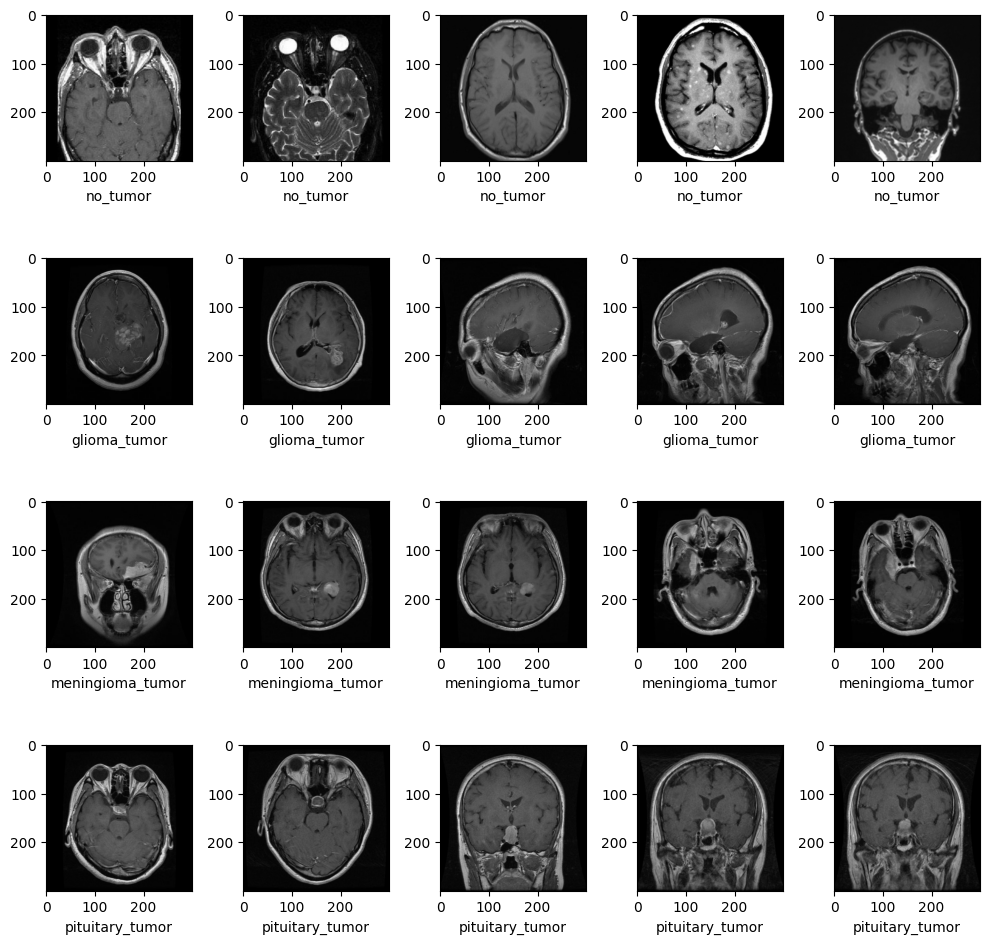

In [61]:
# train_img sample
fig, ax = plt.subplots(4, 5, figsize=(10, 10))

for i in range(4):
    for j in range(5):
        ax[i][j].imshow(train_img[start_idx_labels[i]+j])
        ax[i][j].set_xlabel(train_label[start_idx_labels[i]+j])

plt.tight_layout()
plt.show()

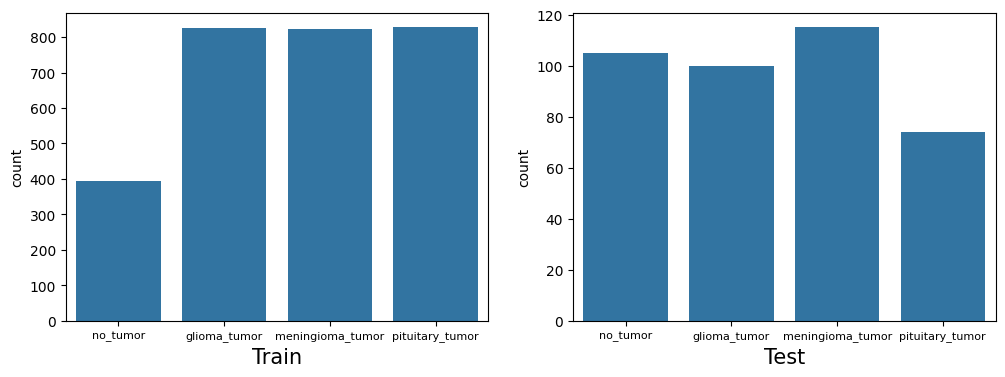

In [85]:
# label별 개수 비교
plt.figure(figsize=(12, 4))
xlabel = ['Train', 'Test']

for idx, data in enumerate([train_label, test_label]):
    plt.subplot(1, 2, idx+1)
    sns.countplot(x=data, order=['no_tumor', 'glioma_tumor', 'meningioma_tumor', 'pituitary_tumor'])
    plt.xlabel(xlabel[idx], fontsize=15)
    plt.xticks(fontsize=8)

plt.show()

## 3. Model

In [86]:
# train data split
train_x, val_x, train_y, val_y = train_test_split(train_img, np.array(train_label), test_size=0.1)
train_x.shape, train_y.shape, val_x.shape, val_y.shape

((2583, 300, 300, 3), (2583,), (287, 300, 300, 3), (287,))

### 1) Baseline 

* Classification
* Tensorflow/Keras

In [87]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(kernel_size=(5, 5), filters=32, activation='relu', padding='same'), # padding -> 이미지 크기 유지
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)), # 이미지 크기가 절반으로 감소

    tf.keras.layers.Conv2D(kernel_size=(3, 3), filters=32, activation='relu', padding='same'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(kernel_size=(3, 3), filters=32, activation='relu', padding='same'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(kernel_size=(3, 3), filters=64, activation='relu', padding='same'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5), # 과적합 방지
    tf.keras.layers.Dense(4, activation='sigmoid')
])

In [94]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [95]:
history = model.fit(tf.cast(train_img, tf.float32), np.array(pd.get_dummies(train_label)), validation_split=0.1, epochs=20, verbose=1, batch_size=32)

Epoch 1/20
81/81 [==============================] - 68s 826ms/step - loss: 3.7795 - accuracy: 0.5103 - val_loss: 1.0534 - val_accuracy: 0.4077
Epoch 2/20
81/81 [==============================] - 68s 839ms/step - loss: 0.8237 - accuracy: 0.6531 - val_loss: 0.8781 - val_accuracy: 0.6307
Epoch 3/20
81/81 [==============================] - 68s 840ms/step - loss: 0.6092 - accuracy: 0.7499 - val_loss: 0.8600 - val_accuracy: 0.5819
Epoch 4/20
81/81 [==============================] - 69s 853ms/step - loss: 0.4454 - accuracy: 0.8269 - val_loss: 0.5605 - val_accuracy: 0.7561
Epoch 5/20
81/81 [==============================] - 69s 848ms/step - loss: 0.3497 - accuracy: 0.8684 - val_loss: 0.7690 - val_accuracy: 0.6934
Epoch 6/20
81/81 [==============================] - 68s 845ms/step - loss: 0.2767 - accuracy: 0.8978 - val_loss: 0.5482 - val_accuracy: 0.7666
Epoch 7/20
81/81 [==============================] - 69s 852ms/step - loss: 0.2298 - accuracy: 0.9199 - val_loss: 0.4306 - val_accuracy: 0.8397

In [103]:
print('1st CNN\'s weights shape:', model.layers[0].get_weights()[0].shape) # 첫 번재 layer의 가중치 행렬
print('2nd CNN\'s weights shape:', model.layers[2].get_weights()[0].shape)
print('3rd CNN\'s weights shape:', model.layers[4].get_weights()[0].shape)
print('4th CNN\'s weights shape:', model.layers[6].get_weights()[0].shape)
print('Output shape:', model.output_shape)

1st CNN's weights shape: (5, 5, 3, 32)
2nd CNN's weights shape: (3, 3, 32, 32)
3rd CNN's weights shape: (3, 3, 32, 32)
4th CNN's weights shape: (3, 3, 32, 64)
Output shape: (None, 4)
